In [ ]:
import re
import string
from tqdm import tqdm
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

stopwords_set = set(stopwords.words('english'))

def tokenize(document):
    tokens = [token.lower() for token in document.split()]
    punc_patt = re.compile(rf'[{string.punctuation}]')
    tokens = [punc_patt.sub('',token) for token in tokens]
    tokens = [token for token in tokens if not token in stopwords_set]
    return tokens

def get_similarity(headline,body):
    headline_tokens = set(tokenize(headline))
    bodies_token = set(tokenize(body))
    intersec = headline_tokens.intersection(bodies_token)
    return len(intersec)
                           

def process_data(bodies_path,stances_path,folder_prefix="fnc-1"):
    complete_bodies_path = '/'.join((folder_prefix,bodies_path))
    complete_stances_path = '/'.join((folder_prefix,stances_path))
    
    df_bodies = pd.read_csv(complete_bodies_path)
    df_stances = pd.read_csv(complete_stances_path)
    df_all = pd.merge(df_stances,df_bodies,on ="Body ID")
    
    X = []
    Y = [0 if stance == "unrelated" else 1 for stance in df_all["Stance"] ]
    for headline, body_id, stance, articleBody in tqdm(df_all.values):
        similarity = get_similarity(headline,articleBody)
        X.append(similarity)
    return np.array(X).reshape(-1,1), np.array(Y)

X_train, Y_train = process_data('train_bodies.csv','train_stances.csv')
X_test, Y_test = process_data('competition_test_bodies.csv','competition_test_stances.csv')



In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

algorithms = [
    ("Decision Tree",DecisionTreeClassifier()),
    ("Logistic Regression",LogisticRegression(solver="lbfgs")),
    ("Naive Bayes",MultinomialNB()),
    ("LDA",LinearDiscriminantAnalysis()),
    ("Kneighbors",KNeighborsClassifier(3))
]

for name,algorithm in algorithms:
    algorithm.fit(X_train,Y_train)
    print(name)
    accuracy_test = accuracy_score(Y_test,algorithm.predict(X_test))
    accuracy_train = accuracy_score(Y_train,algorithm.predict(X_train))
    
    print(f"Test : {accuracy_test}")
    print(f"Train : {accuracy_train}")
    print("="*50)

Decision Tree
Test : 0.9403454924644867
Train : 0.9410870087248859
Logistic Regression
Test : 0.9403454924644867
Train : 0.9410870087248859
Naive Bayes
Test : 0.7220320308503522
Train : 0.7313095333386697
LDA
Test : 0.9098492897336009
Train : 0.9205354998799328
Kneighbors
Test : 0.9098492897336009
Train : 0.9205354998799328


### PR Curve

For our model , we would like to have a high precision model, because it is more costly to missclasify an article as related if it was actually unrelated then the inverse. So we're aiming for around ~ 98

(0.9182237559109696, 0.9747364233141038, 0.6936579841449604)


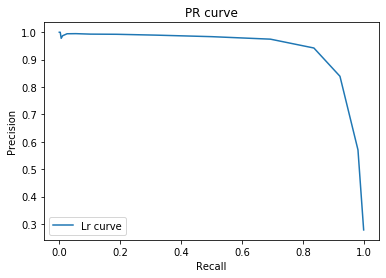

In [82]:
import matplotlib.pyplot as plt
log_reg = LogisticRegression(solver="lbfgs")
log_reg.fit(X_train,Y_train)

def find_matching_point(thresholds,precisions,recalls,desired_precision):
    for threshold,precision, recall in zip(thresholds,precisions,recalls):
        if precision > desired_precision:
            return (threshold,precision,recall)

preds = log_reg.predict_proba(X_test)[:,1]

precisions, recalls, thresholds = precision_recall_curve(Y_test,preds)
plt.plot(recalls,precisions,label="Lr curve")
plt.legend()


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR curve")
print(find_matching_point(thresholds,precisions,recalls,0.97))
plt.show()

In [76]:
import pickle
with open("log_reg.pickle","wb") as f:
    pickle.dump(log_reg,f)
threshold,*_ = find_matching_point(thresholds,precisions,recalls,desired_precision=0.97)
with open("threshold.txt","w") as f:
    f.write(str(threshold))
print("DONE")

DONE
